In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string
import statistics

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Verify TensorFlow version and Keras version

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.1


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


In [6]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15858409215515895968
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1296408576
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2676779958913818792
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
# # register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
# !python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

In [10]:
# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')

In [11]:
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

In [12]:
text_only_dataset_all=dataset_all.map(lambda x, y: x)

In [13]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [14]:
categories =dict(enumerate(info.features["label"].names))
print(f'Dictionary: ',categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [15]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [16]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [17]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [18]:
STOPWORDS

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
##############################################
# GLOBAL layers.TextVectorization() Settings #
##############################################
max_tokens=None # default
output_sequence_length=None # default
# STOPWORDS: default nltk stopwords

In [20]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')



In [32]:
# %%time
# # EDA layers.TextVectorization(): text_vectorization

# text_vectorization=layers.TextVectorization(
#     max_tokens=max_tokens,
#     output_mode="int",
#     standardize=custom_stopwords,
#     output_sequence_length=output_sequence_length
# )
# text_vectorization.adapt(text_only_dataset_all)

CPU times: total: 7min 54s
Wall time: 4min 55s


In [20]:
# %%time
# doc_sizes = []
# corpus = []
# for example, _ in dataset_all.as_numpy_iterator():
#   enc_example = text_vectorization(example)
#   doc_sizes.append(len(enc_example))
#   corpus+=list(enc_example.numpy())

CPU times: total: 17min 22s
Wall time: 16min 31s


In [21]:
# print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
# print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 2579419 words in the corpus of 127600 news articles.
Each news article has between 2 and 95 tokens in it.


In [22]:
# statistics.mean(doc_sizes)

20.214882445141065

In [23]:
# print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")

There are 95827 vocabulary words in the corpus.


In [24]:
# vocab = np.array(text_vectorization.get_vocabulary())
# print(vocab[:50])

['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced']


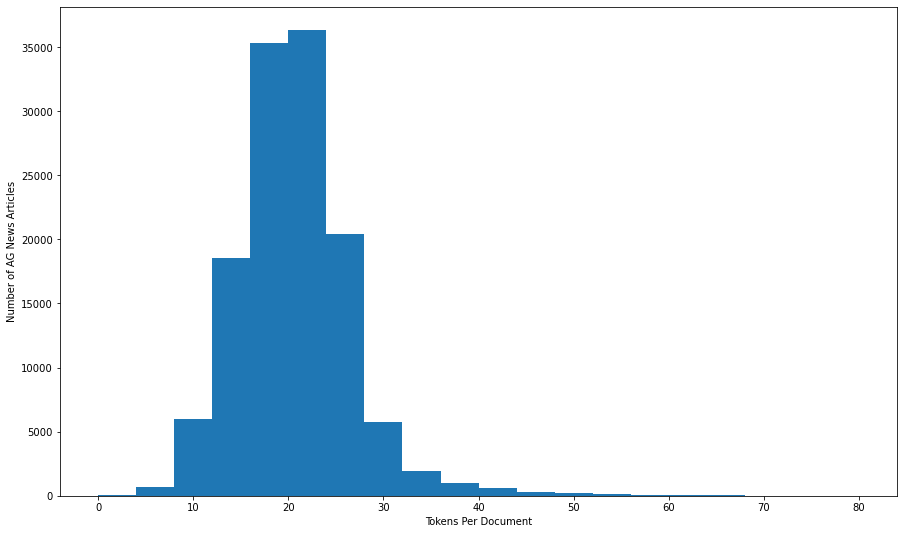

In [25]:
# plt.figure(figsize=(15,9))
# plt.hist(doc_sizes, bins=20,range = (0,80))
# plt.xlabel("Tokens Per Document")
# plt.ylabel("Number of AG News Articles");

## Experiments: Dataset Split

- split into train, validation, test datasets

In [21]:
dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

## layers.TextVectorization() Settings

- max_tokens: None (Default)
- output_seqnence_length: None (Default)
- STOPWORDS: default nltk stopwords

In [22]:
print(output_sequence_length)

None


In [23]:
print(max_tokens)

None


In [24]:
%%time
###################################################
# layers.TextVectorization() Experiment Settings: #
###################################################
# max_tokens=None # default
# output_sequence_length=None # default
# STOPWORDS: default nltk stopwords

# Experiment layers.TextVectorization(): text_vectorization_exp

text_vectorization_exp = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords,
    output_sequence_length=output_sequence_length
)
text_vectorization_exp.adapt(text_only_train_ds)

CPU times: total: 15.2 s
Wall time: 6.05 s


In [25]:
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization_exp(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization_exp(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization_exp(x), y),
    num_parallel_calls=4)

### Experiment 1: LSTM

- layers.TextVectorization(output_sequence_length): None (default)
- layers.Dropout(dropout): 0.2 (constant)
- layers.Bidirectional(layers.LSTM(units)): 32 (constant)
- layers.Embedding(output_dim): 64 (variable)
- layers.Embedding(input_dim): 1000 (constant)

In [26]:
# output_sequence_length=None # default
dropout = 0.2 # constant
units = 32 # constant
output_dim = 64 # variable
input_dim = 1000 # constant

In [25]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=input_dim
                            ,output_dim=output_dim
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(units))(embedded)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_01 = tf.keras.Model(inputs, outputs)
model_01.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_01.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_01_osl_def_od_64.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model_01.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model_01 = keras.models.load_model("LSTM_01_osl_def_od_64.h5")
print(f"Test acc: {model_01.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 89,092
Trainable params: 89,092
Non-trainable params: 0
_________________________________________________________

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
13,0.312,0.889,0.377,0.866
14,0.307,0.891,0.380,0.868
15,0.301,0.893,0.385,0.865
16,0.298,0.895,0.390,0.864
17,0.292,0.897,0.388,0.865


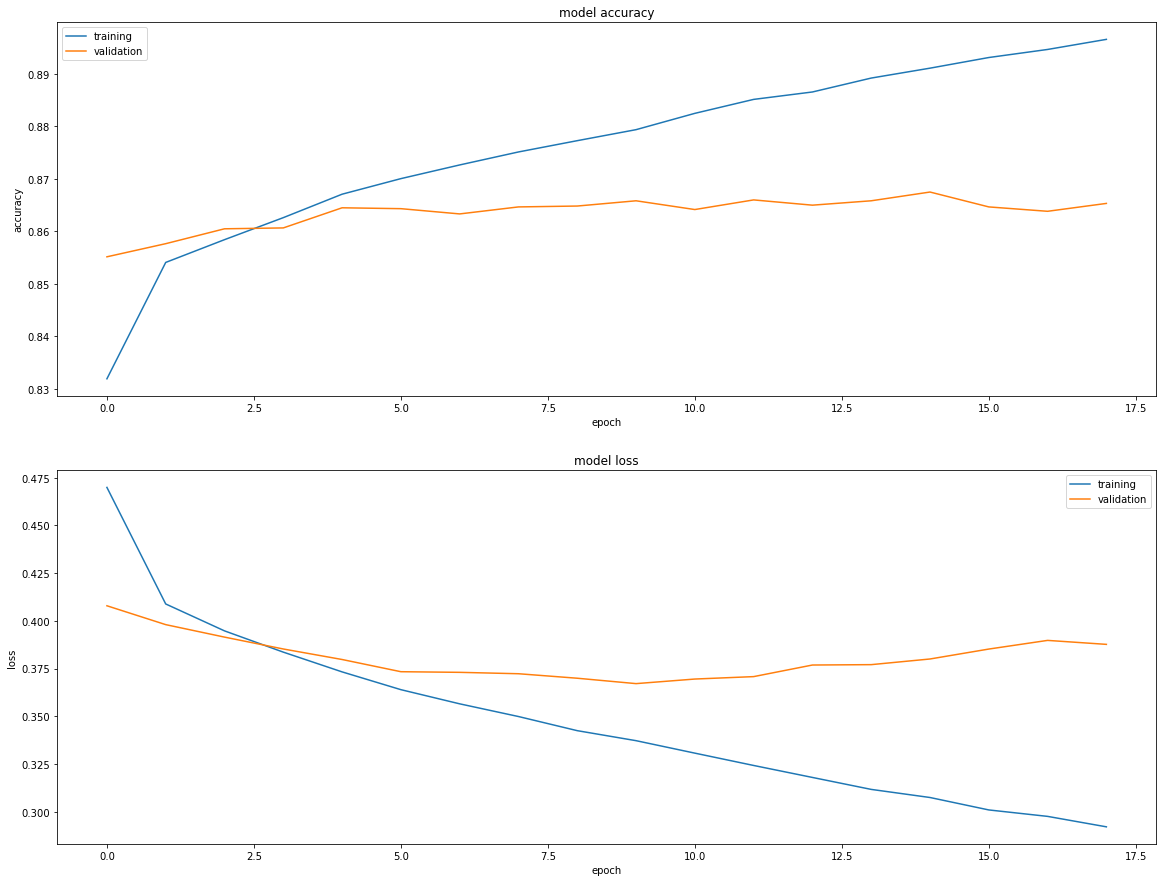

In [28]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [29]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_01.predict(int_test_ds), axis=-1)

238/238 [==============================] - 4s 6ms/step


In [30]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1900
           1       0.92      0.94      0.93      1900
           2       0.86      0.82      0.84      1900
           3       0.82      0.83      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8660526315789474
Root Mean Square Error: 0.65484027783398


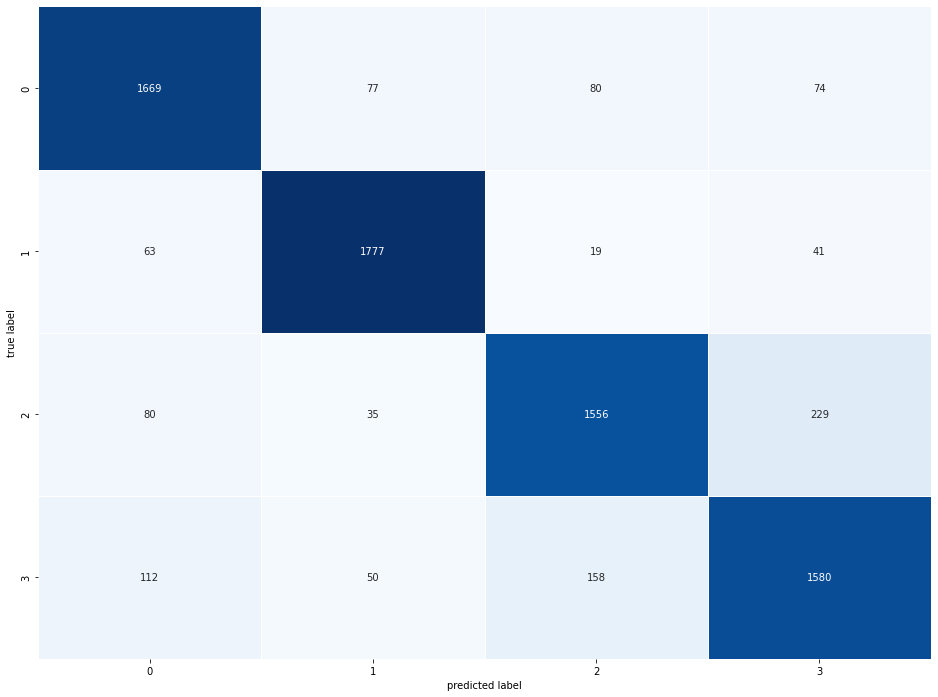

In [31]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 2: LSTM

- layers.TextVectorization(output_sequence_length): None (default)
- layers.Dropout(dropout): 0.2 (constant)
- layers.Bidirectional(layers.LSTM(units)): 32 (constant)
- layers.Embedding(output_dim): 128 (VARIABLE)
- layers.Embedding(input_dim): 1000 (constant)

In [46]:
output_dim = 128 # variable

In [47]:
print('input_dim:', input_dim)
print('output_dim:', output_dim)
print('units:', units)
print('dropout:', dropout)
print('output_sequence_length:', output_sequence_length)

input_dim: 1000
output_dim: 128
units: 32
dropout: 0.2
output_sequence_length: None


In [48]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=input_dim
                            ,output_dim=output_dim
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(units))(embedded)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_02 = tf.keras.Model(inputs, outputs)
model_02.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_02.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_02_osl_def_od_128.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model_02.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model_02 = keras.models.load_model("LSTM_02_osl_def_od_128.h5")
print(f"Test acc: {model_02.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 169,476
Trainable params: 169,476
Non-trainable params: 0
_______________________________________________________

In [49]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,0.340,0.879,0.380,0.867
8,0.331,0.883,0.384,0.867
9,0.324,0.886,0.386,0.866
10,0.316,0.889,0.389,0.865
11,0.308,0.892,0.392,0.865


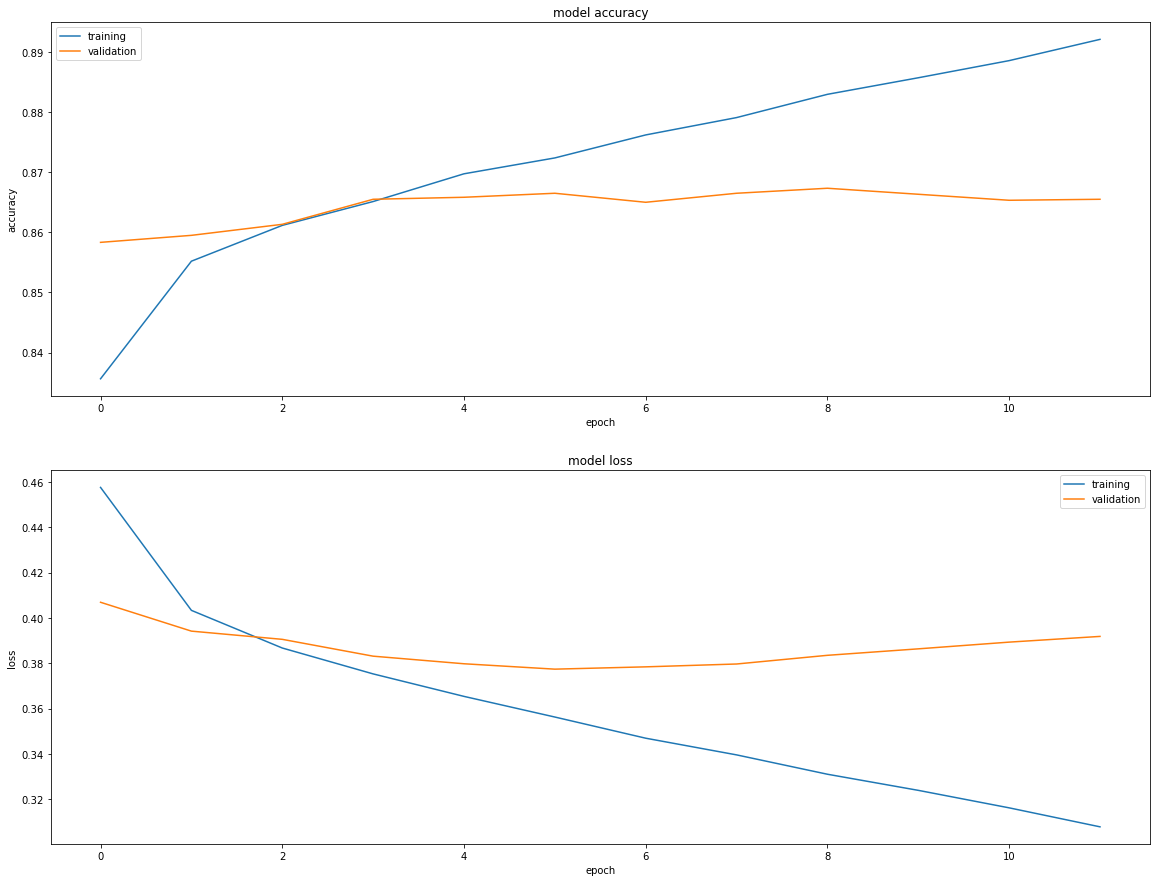

In [51]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [52]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_02.predict(int_test_ds), axis=-1)

238/238 [==============================] - 4s 6ms/step


In [53]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1900
           1       0.90      0.94      0.92      1900
           2       0.86      0.81      0.83      1900
           3       0.82      0.83      0.83      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8640789473684211
Root Mean Square Error: 0.6491897784323569


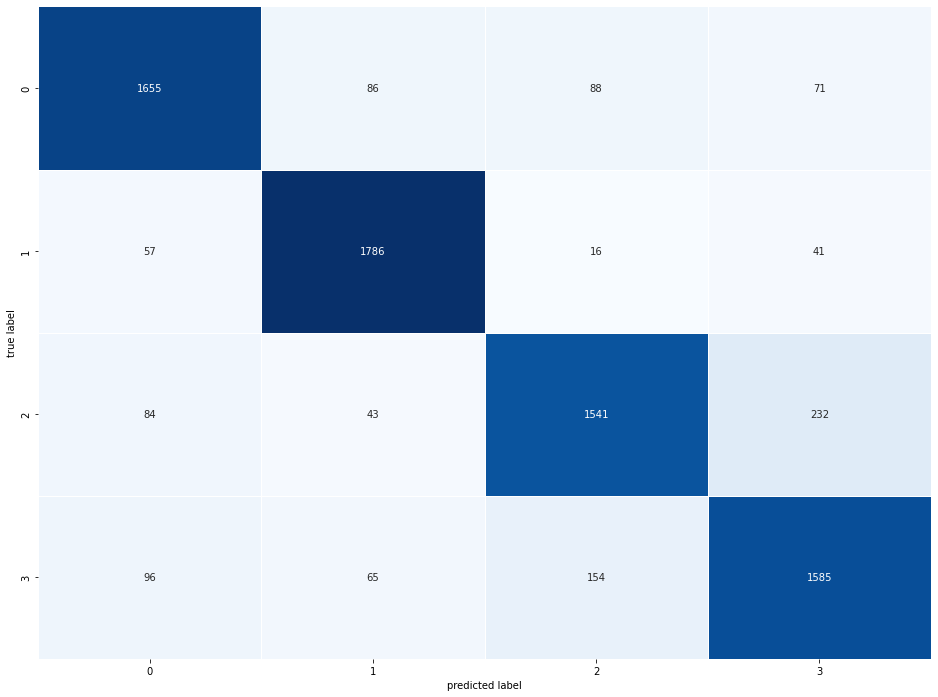

In [54]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 3: LSTM

- layers.TextVectorization(output_sequence_length): None (default)
- layers.Dropout(dropout): 0.2 (constant)
- layers.Bidirectional(layers.LSTM(units)): 32 (constant)
- layers.Embedding(output_dim): 256 (VARIABLE)
- layers.Embedding(input_dim): 1000 (constant)

In [30]:
output_dim = 256 # variable

In [31]:
print('input_dim:', input_dim)
print('output_dim:', output_dim)
print('units:', units)
print('dropout:', dropout)
print('output_sequence_length:', output_sequence_length)

input_dim: 1000
output_dim: 256
units: 32
dropout: 0.2
output_sequence_length: None


In [32]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=input_dim
                            ,output_dim=output_dim
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(units))(embedded)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_03 = tf.keras.Model(inputs, outputs)
model_03.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_03.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_03_osl_DEF_od_256.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model_03.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model_03 = keras.models.load_model("LSTM_03_osl_DEF_od_256.h5")
print(f"Test acc: {model_03.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               73984     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 330,244
Trainable params: 330,244
Non-trainable params: 0
_______________________________________________________

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
5,0.351,0.875,0.385,0.864
6,0.340,0.878,0.385,0.865
7,0.332,0.882,0.387,0.864
8,0.320,0.886,0.389,0.864
9,0.309,0.890,0.396,0.863


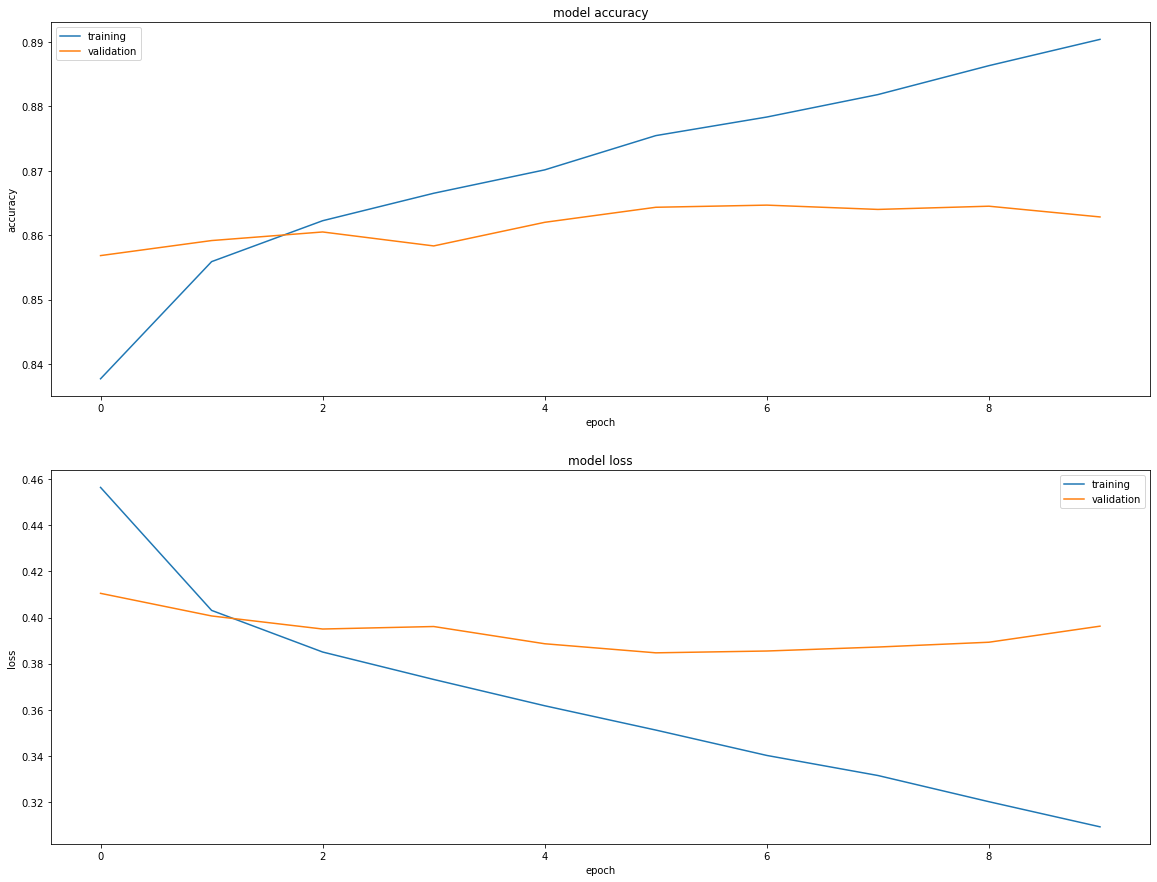

In [35]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [36]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_03.predict(int_test_ds), axis=-1)

238/238 [==============================] - 5s 8ms/step


In [37]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1900
           1       0.91      0.94      0.92      1900
           2       0.85      0.81      0.83      1900
           3       0.83      0.83      0.83      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8628947368421053
Root Mean Square Error: 0.6582472739664104


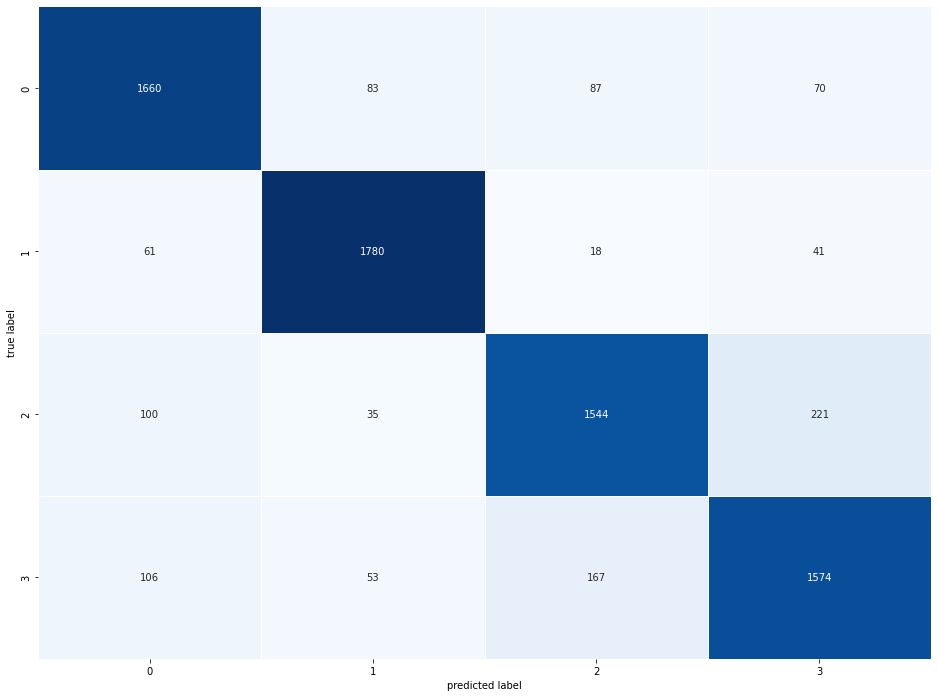

In [38]:
plot_confusion_matrix(y_test,pred_classes)